In [1]:
#Load libraries

import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
import shap
import lime
import lime.lime_tabular
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.svm import SVC
#print('done')

In [2]:
#Load income dataset

dataset = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
row_names = ["Age", "Workclass", "Fnlwgt", "Education", "EducationNum", "MaritalStatus",
        "Occupation", "Relationship", "Race", "Gender", "CapitalGain", "CapitalLoss",
        "HoursPerWeek", "Country", "Income"]
us_adult_income = pd.read_csv(dataset, names=row_names,na_values=[' ?'])

In [3]:
#Basic preprocessing and one hot encoding

del us_adult_income['CapitalGain']
del us_adult_income['CapitalLoss']
del us_adult_income['Education']
del us_adult_income['Relationship']
del us_adult_income['Country']

#print(us_adult_income)

one_hot_encoding = pd.get_dummies(us_adult_income)
one_hot_encoding.fillna(one_hot_encoding.mean(),inplace=True)
one_hot_encoding["Income"] = one_hot_encoding['Income_ >50K']
del one_hot_encoding['Income_ <=50K']
del one_hot_encoding['Income_ >50K']


#Split X, Y and create train test dataset
X = one_hot_encoding.iloc[:,0:-1]
Y = one_hot_encoding.iloc[:,-1]
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)

In [4]:
#Build the random forest classifier
rf = RandomForestClassifier(max_depth=6, random_state=0, n_estimators=10)
rf.fit(X_train, Y_train)

yPredRf = rf.predict(X_test)
print(metrics.classification_report(Y_test, yPredRf))

              precision    recall  f1-score   support

           0       0.84      0.96      0.89      6214
           1       0.74      0.40      0.52      1927

    accuracy                           0.82      8141
   macro avg       0.79      0.68      0.71      8141
weighted avg       0.81      0.82      0.80      8141



Text(0, 0.5, 'Cross-validated accuracy')

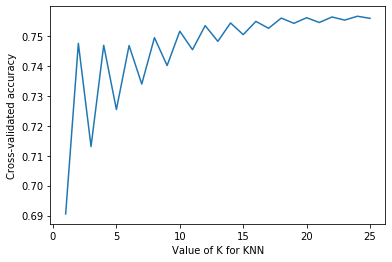

In [5]:
#Start KNN implementation. Do elbow method to define number of K

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
# Number of k from 1 to 26
k_range = range(1, 26)
k_scores = []
# Calculate cross validation score for every k number from 1 to 26
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    # It’s 10 fold cross validation with ‘accuracy’ scoring 
    scores = cross_val_score(knn, X, Y, cv=10, scoring='accuracy') 
    k_scores.append(scores.mean())
    
%matplotlib inline
# Plot accuracy for every k number between 1 and 26
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-validated accuracy')

In [6]:
# Train the KNN model and use k=18 based on above graph

knn = KNeighborsClassifier(n_neighbors=18)
knn.fit(X_train, Y_train)
yPredKNN = knn.predict(X_test)

# classification report for test set
print(metrics.classification_report(Y_test, yPredKNN))

              precision    recall  f1-score   support

           0       0.76      0.99      0.86      6214
           1       0.35      0.02      0.04      1927

    accuracy                           0.76      8141
   macro avg       0.56      0.50      0.45      8141
weighted avg       0.67      0.76      0.67      8141



In [7]:
#Train the GNB model

gnb=GaussianNB()
gnb.fit(X_train,Y_train)

yPredGNB = gnb.predict(X_test)


# classification report for test set
print(metrics.classification_report(Y_test, yPredGNB))

              precision    recall  f1-score   support

           0       0.79      0.97      0.87      6214
           1       0.65      0.18      0.29      1927

    accuracy                           0.78      8141
   macro avg       0.72      0.58      0.58      8141
weighted avg       0.76      0.78      0.73      8141



In [8]:
#Train the XGB model

xgbModel = xgb.XGBClassifier(random_state=1)
xgbModel.fit(X_train, Y_train)
yPredXGB = xgbModel.predict(X_test)
print(metrics.classification_report(Y_test, yPredXGB))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      6214
           1       0.69      0.59      0.63      1927

    accuracy                           0.84      8141
   macro avg       0.78      0.75      0.77      8141
weighted avg       0.83      0.84      0.83      8141



In [9]:
#LIME implementation

#Create the explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns.values.tolist(),
                                                class_names=['Income < 50K', 'Income > 50k'], verbose=True, mode='classification')


#Select a specific index and plot local explanation for desired data point
j = 2

print("KNN ", "Predicted: ", yPredKNN[j], " ", "Actual: ", Y_test.values[j])
exp = explainer.explain_instance(X_test.values[j], knn.predict_proba, num_features=6)
exp.show_in_notebook(show_table=True)

print("GNB ", "Predicted: ", yPredGNB[j], " ", "Actual: ", Y_test.values[j])
exp = explainer.explain_instance(X_test.values[j], gnb.predict_proba, num_features=6)
exp.show_in_notebook(show_table=True)

print("RF ", "Predicted: ", yPredRf[j], " ", "Actual: ", Y_test.values[j])
exp = explainer.explain_instance(X_test.values[j], rf.predict_proba, num_features=6)
exp.show_in_notebook(show_table=True)

KNN  Predicted:  0   Actual:  1
Intercept 0.20993293956925896
Prediction_local [0.22063632]
Right: 0.3333333333333333


GNB  Predicted:  0   Actual:  1
Intercept 0.09739608180669977
Prediction_local [0.38565374]
Right: 0.324157222747309


RF  Predicted:  1   Actual:  1
Intercept 0.03333991425263916
Prediction_local [0.53509357]
Right: 0.571232377844581


Intercept 0.42195704555755276
Prediction_local [0.95197975]
Right: 0.912900250384442
Intercept 0.5655505282492952
Prediction_local [0.94624677]
Right: 0.9514297351627384
Intercept 0.6402359946499943
Prediction_local [0.91686646]
Right: 0.9403087207601454
Intercept 0.5975632518196723
Prediction_local [0.94331827]
Right: 0.9280796563089115
Intercept 0.4898580969068265
Prediction_local [1.01082992]
Right: 0.9402285992455761
Intercept 0.7897353793017204
Prediction_local [0.99558169]
Right: 0.9882267877459835
Intercept 0.7481665490904855
Prediction_local [0.68198272]
Right: 0.8297696025736301
Intercept 0.7770028888656522
Prediction_local [0.79162319]
Right: 0.771266394446235
Intercept 0.5612391206602658
Prediction_local [1.00505651]
Right: 0.9902266425736524
Intercept 0.6411431101293201
Prediction_local [0.82144795]
Right: 0.8619441250270565
Intercept 0.7407026625840383
Prediction_local [0.70993275]
Right: 0.7654481267817024
Intercept 0.6693662912572674
Prediction_local [0.71472815]
Right: 

Prediction_local [1.00038125]
Right: 0.9811962801136904
Intercept 0.7174864568723555
Prediction_local [0.81494214]
Right: 0.8290770636651732
Intercept 0.5421733288076176
Prediction_local [0.9764896]
Right: 0.9658215248532122
Intercept 0.8020768025318733
Prediction_local [0.70588263]
Right: 0.7523502854707342
Intercept 0.9390309490943122
Prediction_local [0.65278775]
Right: 0.5416402293333097
Intercept 0.744176517538091
Prediction_local [0.73864991]
Right: 0.6458735443544723
Intercept 0.5890999783281703
Prediction_local [0.8651589]
Right: 0.9404603199609303
Intercept 0.5201764672554661
Prediction_local [1.08688377]
Right: 0.9809095230751085
Intercept 1.0176376234455522
Prediction_local [0.62998337]
Right: 0.5974024507885611
Intercept 0.7325602954407044
Prediction_local [0.95833823]
Right: 0.955440516552936
Intercept 0.713389695365192
Prediction_local [0.67158337]
Right: 0.659438384845916
Intercept 0.8249474270448789
Prediction_local [0.5959449]
Right: 0.6247148335191339
Intercept 0.8899

Intercept 0.7867132621224601
Prediction_local [0.87955627]
Right: 0.9459925749347624
Intercept 0.10432570761498643
Prediction_local [0.44372337]
Right: 0.5833305101067039
Intercept 0.8919901570420579
Prediction_local [0.58908455]
Right: 0.5766564396075289
Intercept 0.7979359452182296
Prediction_local [0.73034396]
Right: 0.6020806842188008
Intercept -0.009887087255347371
Prediction_local [0.49774198]
Right: 0.7081792355085389
Intercept 0.6633769964530101
Prediction_local [0.68651513]
Right: 0.8501547632637735
Intercept 0.07686108373638711
Prediction_local [0.47165341]
Right: 0.5795806671616104
Intercept 0.9917557777224317
Prediction_local [0.60862244]
Right: 0.5557335958396509
Intercept 0.8851331221191572
Prediction_local [0.60702386]
Right: 0.5571516664343025
Intercept 0.6983746999300524
Prediction_local [0.7866118]
Right: 0.771266394446235
Intercept 0.7239374799020926
Prediction_local [0.89485591]
Right: 0.943368081490739
Intercept 0.5897134876186365
Prediction_local [0.90988182]
Righ

Intercept 0.7589152167702555
Prediction_local [0.79531454]
Right: 0.8772264424669911
Intercept 1.0295982022768606
Prediction_local [0.58262612]
Right: 0.6054667511931446
Intercept 0.6611296628941234
Prediction_local [0.9990908]
Right: 0.9770379119640407
Intercept 0.43938369698750407
Prediction_local [1.00945646]
Right: 0.9703534924024341
Intercept 0.05040204970763787
Prediction_local [0.55843422]
Right: 0.6821273687422276
Intercept 0.9519793384742562
Prediction_local [0.64622466]
Right: 0.6658259034246746
Intercept 0.7558357893419866
Prediction_local [0.67506113]
Right: 0.8840798065684028
Intercept 0.8568902716895923
Prediction_local [0.71300958]
Right: 0.6963052130401566
Intercept 0.8186734532830863
Prediction_local [0.60754765]
Right: 0.5879701475501694
Intercept 0.059032852422593735
Prediction_local [0.50823205]
Right: 0.6488220477094243
Intercept 0.6032542710659388
Prediction_local [0.88791021]
Right: 0.9741799698409259
Intercept 0.6444062425082133
Prediction_local [0.81627914]
Rig

Prediction_local [0.94956406]
Right: 0.9525278160015798
Intercept 0.5039293507873359
Prediction_local [1.059956]
Right: 0.9902266425736524
Intercept 0.8282104876496503
Prediction_local [0.83154542]
Right: 0.8917661371144501
Intercept 0.980504132537301
Prediction_local [0.58874116]
Right: 0.6383991128389768
Intercept 0.7629927895542051
Prediction_local [0.9135589]
Right: 0.8777985971060118
Intercept 0.7241940456358033
Prediction_local [0.71521369]
Right: 0.6283983637216196
Intercept 0.6670629762903515
Prediction_local [0.87798433]
Right: 0.9630165531934682
Intercept 0.6467739637812686
Prediction_local [1.01072229]
Right: 0.9541546917354274
Intercept 0.6087938659493434
Prediction_local [0.93927317]
Right: 0.9151429185363937
Intercept 0.9677704138014375
Prediction_local [0.63352812]
Right: 0.5493812327954948
Intercept 0.7098171288795191
Prediction_local [0.79780309]
Right: 0.7738602064181068
Intercept -0.03154500957188375
Prediction_local [0.53167701]
Right: 0.5412564804628139
Intercept 0

Right: 0.6783106945867377
Intercept 0.8356448618290689
Prediction_local [0.79010762]
Right: 0.8299882127740718
Intercept 0.5480953157896753
Prediction_local [1.09410423]
Right: 0.9889365509368669
Intercept 0.6811696169574941
Prediction_local [0.88336362]
Right: 0.9244279154939639
Intercept 0.8121621086958954
Prediction_local [0.6501914]
Right: 0.6101892594470428
Intercept 0.032305820944316055
Prediction_local [0.49004704]
Right: 0.6516276847424474
Intercept 0.7571983663563966
Prediction_local [0.7121553]
Right: 0.665590938558408
Intercept 1.0161850835859152
Prediction_local [0.6792984]
Right: 0.6573879902744746
Intercept 1.040024935001986
Prediction_local [0.58362985]
Right: 0.5937698656061833
Intercept 0.05789626931286587
Prediction_local [0.47100249]
Right: 0.5795955141134139
Intercept 0.7830377634790104
Prediction_local [0.91129633]
Right: 0.9125129536419166
Intercept 0.5336966121997199
Prediction_local [0.95514167]
Right: 0.9499453900745444
Intercept 0.5338221283225193
Prediction_l

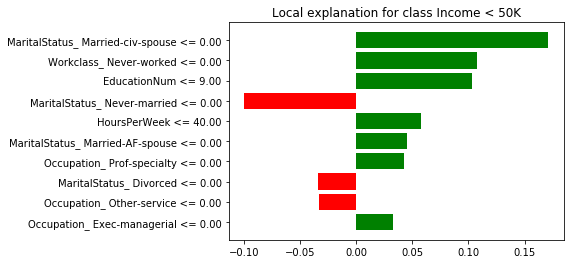

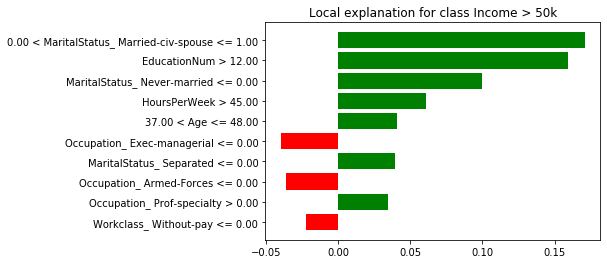

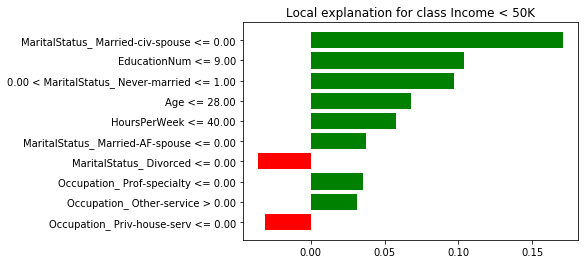

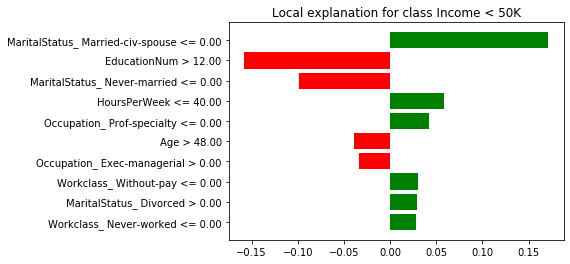

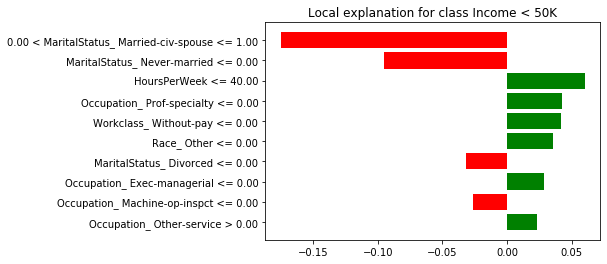

In [10]:
#SP Lime for rf

from lime import submodular_pick
sp_obj = submodular_pick.SubmodularPick(explainer, X_train.values, rf.predict_proba, sample_size=500, num_features=10, num_exps_desired=5)
#Plot the 5 explanations
[exp.as_pyplot_figure(label=exp.available_labels()[0]) for exp in sp_obj.sp_explanations];
# Make it into a dataframe
W_pick=pd.DataFrame([dict(this.as_list(this.available_labels()[0])) for this in sp_obj.sp_explanations]).fillna(0)
 
W_pick['prediction'] = [this.available_labels()[0] for this in sp_obj.sp_explanations]
 
#Making a dataframe of all the explanations of sampled points
W=pd.DataFrame([dict(this.as_list(this.available_labels()[0])) for this in sp_obj.explanations]).fillna(0)
W['prediction'] = [this.available_labels()[0] for this in sp_obj.explanations]


Intercept 0.83489888813567
Prediction_local [0.77516831]
Right: 0.6666666666666666
Intercept 0.8757396501883448
Prediction_local [0.76739641]
Right: 0.7777777777777778
Intercept 0.8898973729366061
Prediction_local [0.74659517]
Right: 0.8888888888888888
Intercept 0.7837270816818889
Prediction_local [0.76368946]
Right: 0.5555555555555556
Intercept 0.8837970320131844
Prediction_local [0.76312005]
Right: 0.5555555555555556
Intercept 0.8000988060380404
Prediction_local [0.7537694]
Right: 0.6111111111111112
Intercept 0.7389217165230064
Prediction_local [0.76494111]
Right: 0.6111111111111112
Intercept 0.7959378438041274
Prediction_local [0.74299205]
Right: 0.6666666666666666
Intercept 0.5839955852026818
Prediction_local [0.74278135]
Right: 0.5555555555555556
Intercept 0.622708540177116
Prediction_local [0.75396756]
Right: 0.7222222222222222
Intercept 0.7262410363461302
Prediction_local [0.76295886]
Right: 0.8888888888888888
Intercept 0.8220200762735623
Prediction_local [0.76343731]
Right: 0.6

Intercept 0.7766059866502342
Prediction_local [0.76949196]
Right: 0.8333333333333334
Intercept 0.7432615465409146
Prediction_local [0.74393722]
Right: 0.9444444444444444
Intercept 0.74094030499575
Prediction_local [0.77091898]
Right: 0.8888888888888888
Intercept 0.6997616159143478
Prediction_local [0.76214181]
Right: 0.8888888888888888
Intercept 0.7580474698975825
Prediction_local [0.77113322]
Right: 0.8333333333333334
Intercept 0.8986609164720197
Prediction_local [0.76359928]
Right: 0.8333333333333334
Intercept 0.6534527293313666
Prediction_local [0.77203267]
Right: 0.7777777777777778
Intercept 0.7720839864961694
Prediction_local [0.74641021]
Right: 0.6666666666666666
Intercept 0.7273529591070417
Prediction_local [0.77119582]
Right: 0.7777777777777778
Intercept 0.7604622925279594
Prediction_local [0.76065652]
Right: 0.6111111111111112
Intercept 0.7440601053163515
Prediction_local [0.75706085]
Right: 0.7222222222222222
Intercept 0.7427698771727952
Prediction_local [0.76502577]
Right: 0

Right: 0.6666666666666666
Intercept 0.8208976388079975
Prediction_local [0.72763682]
Right: 0.7222222222222222
Intercept 0.7225452941781285
Prediction_local [0.76363297]
Right: 0.5555555555555556
Intercept 0.8352675850059871
Prediction_local [0.76180867]
Right: 0.7777777777777778
Intercept 0.7630504850778695
Prediction_local [0.76223425]
Right: 0.8333333333333334
Intercept 0.2888512375707548
Prediction_local [0.22666051]
Right: 0.5
Intercept 0.673979680094214
Prediction_local [0.74381536]
Right: 0.8888888888888888
Intercept 0.7046142664205459
Prediction_local [0.7743331]
Right: 0.8333333333333334
Intercept 0.7433210863245668
Prediction_local [0.77281492]
Right: 0.7222222222222222
Intercept 0.8005701121487918
Prediction_local [0.73757595]
Right: 0.8333333333333334
Intercept 0.7814619585926675
Prediction_local [0.75111121]
Right: 0.6111111111111112
Intercept 0.8048833563146456
Prediction_local [0.77341179]
Right: 0.7777777777777778
Intercept 0.9599368905637503
Prediction_local [0.7397465

Right: 0.7222222222222222
Intercept 0.8880385537068634
Prediction_local [0.76211707]
Right: 0.7777777777777778
Intercept 0.7925800135750627
Prediction_local [0.74959313]
Right: 0.8333333333333334
Intercept 0.7679910793436364
Prediction_local [0.73742889]
Right: 0.8333333333333334
Intercept 0.16551915462595457
Prediction_local [0.25351992]
Right: 0.6666666666666666
Intercept 0.8022630136845308
Prediction_local [0.77670751]
Right: 0.7222222222222222
Intercept 0.6953471212631175
Prediction_local [0.77565941]
Right: 0.7222222222222222
Intercept 0.7393071056020529
Prediction_local [0.74616555]
Right: 0.8333333333333334
Intercept 0.8269948837262793
Prediction_local [0.77324966]
Right: 0.7777777777777778
Intercept 0.6509269799750428
Prediction_local [0.77389743]
Right: 0.6666666666666666
Intercept 0.7230742705688927
Prediction_local [0.78548563]
Right: 0.7777777777777778
Intercept 0.8866984877657381
Prediction_local [0.75851899]
Right: 0.9444444444444444
Intercept 0.6700485086600173
Predictio

Right: 0.7222222222222222
Intercept 0.7815844576090338
Prediction_local [0.76249592]
Right: 0.7222222222222222
Intercept 0.737947546319818
Prediction_local [0.75108752]
Right: 0.8888888888888888
Intercept 0.8504983567713407
Prediction_local [0.76139824]
Right: 0.7222222222222222
Intercept 0.8023325438302075
Prediction_local [0.7464599]
Right: 0.8333333333333334
Intercept 0.7374355705843351
Prediction_local [0.78044336]
Right: 0.5555555555555556
Intercept 0.6268436575114884
Prediction_local [0.74304217]
Right: 0.8333333333333334
Intercept 0.7842900018934864
Prediction_local [0.76927776]
Right: 0.7777777777777778
Intercept 0.6364946325221595
Prediction_local [0.76312347]
Right: 0.7222222222222222
Intercept 0.6474346760204314
Prediction_local [0.72449002]
Right: 0.8333333333333334
Intercept 0.8137946257299797
Prediction_local [0.69792783]
Right: 0.6666666666666666
Intercept 0.8269433463231761
Prediction_local [0.74646937]
Right: 0.5555555555555556
Intercept 0.8365687280639472
Prediction_l

Right: 0.6666666666666666
Intercept 0.7724547031349649
Prediction_local [0.76823957]
Right: 0.7222222222222222
Intercept 0.7847057889101814
Prediction_local [0.74667531]
Right: 0.7777777777777778
Intercept 0.7515214837471902
Prediction_local [0.75874788]
Right: 0.6666666666666666
Intercept 0.8780710315163912
Prediction_local [0.75009543]
Right: 0.8333333333333334
Intercept 0.8372811675431017
Prediction_local [0.7605794]
Right: 0.7222222222222222
Intercept 0.9838817807917097
Prediction_local [0.74659617]
Right: 0.7222222222222222
Intercept 0.6775163589614162
Prediction_local [0.77056213]
Right: 0.8888888888888888
Intercept 0.827065451504437
Prediction_local [0.76022091]
Right: 0.6111111111111112
Intercept 0.8143886263255555
Prediction_local [0.78120578]
Right: 0.8888888888888888
Intercept 0.8921192735897286
Prediction_local [0.7504078]
Right: 0.7777777777777778
Intercept 0.5695984106238249
Prediction_local [0.78385963]
Right: 0.7777777777777778
Intercept 0.5549462723255603
Prediction_lo

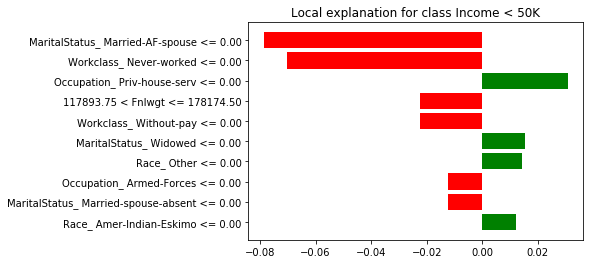

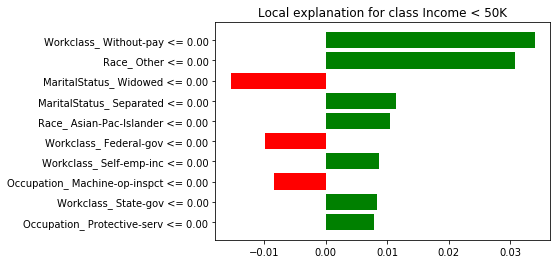

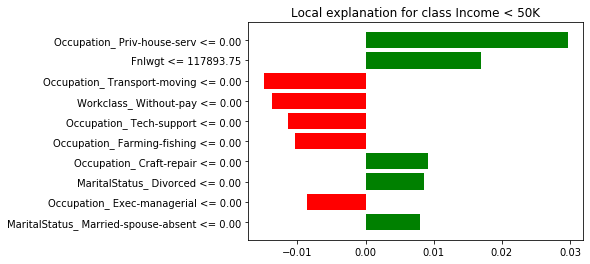

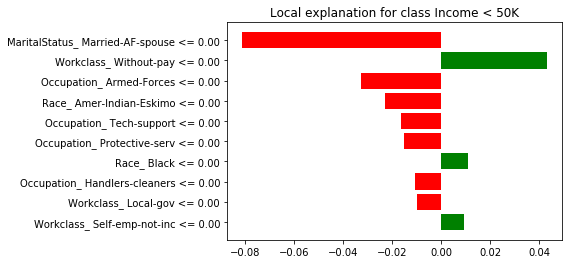

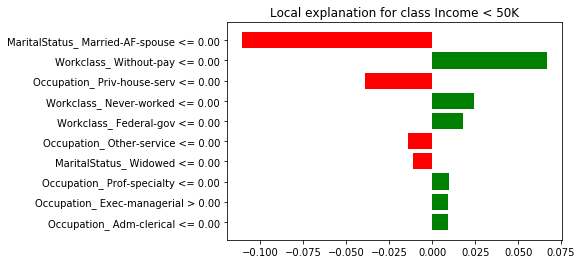

In [11]:
#SP Lime for knn

sp_obj = submodular_pick.SubmodularPick(explainer, X_train.values, knn.predict_proba, sample_size=500, num_features=10, num_exps_desired=5)
#Plot the 5 explanations
[exp.as_pyplot_figure(label=exp.available_labels()[0]) for exp in sp_obj.sp_explanations];
# Make it into a dataframe
W_pick=pd.DataFrame([dict(this.as_list(this.available_labels()[0])) for this in sp_obj.sp_explanations]).fillna(0)
 
W_pick['prediction'] = [this.available_labels()[0] for this in sp_obj.sp_explanations]
 
#Making a dataframe of all the explanations of sampled points
W=pd.DataFrame([dict(this.as_list(this.available_labels()[0])) for this in sp_obj.explanations]).fillna(0)
W['prediction'] = [this.available_labels()[0] for this in sp_obj.explanations]


Intercept 0.6977803343638702
Prediction_local [0.91758175]
Right: 0.9341309024931833
Intercept 0.8866632434916673
Prediction_local [0.69121367]
Right: 0.6061487859349929
Intercept 0.49813168558194054
Prediction_local [1.0151531]
Right: 0.986307661668308
Intercept 0.5453992236173135
Prediction_local [1.02106542]
Right: 0.9670745879197818
Intercept 0.16080641765661083
Prediction_local [0.35727596]
Right: 0.5494393585442985
Intercept 0.7941783543435212
Prediction_local [0.72765684]
Right: 0.6344256097754702
Intercept 0.6556606668969002
Prediction_local [0.81412328]
Right: 0.7769667734941578
Intercept 0.6488484871202098
Prediction_local [0.7911659]
Right: 0.9644919120131722
Intercept 0.5920027873583946
Prediction_local [1.01080661]
Right: 0.8907248040978263
Intercept 0.6170067698870627
Prediction_local [0.79575273]
Right: 0.7683409460409143
Intercept 0.6444234334237218
Prediction_local [0.71397091]
Right: 0.6216570020384539
Intercept 0.8570035225887822
Prediction_local [0.66461836]
Right: 

Right: 0.6642374163865395
Intercept 0.6858105349860609
Prediction_local [0.90862493]
Right: 0.967015646765637
Intercept 0.688594471765896
Prediction_local [0.8701282]
Right: 0.7779221116183656
Intercept 0.8022988577642142
Prediction_local [0.63068473]
Right: 0.5774062271843984
Intercept 0.7553711496524835
Prediction_local [0.76855462]
Right: 0.624543933014583
Intercept 0.7964337179543041
Prediction_local [0.89887568]
Right: 0.9345075974101845
Intercept 0.6301608245595013
Prediction_local [0.78907075]
Right: 0.7125381266519437
Intercept 0.6220950654798844
Prediction_local [1.00196733]
Right: 0.991426499812156
Intercept 0.6529171309932722
Prediction_local [0.75318046]
Right: 0.6575214635681486
Intercept 0.76868430785282
Prediction_local [0.84381858]
Right: 0.7888078113474941
Intercept 0.6300963588231148
Prediction_local [0.79787093]
Right: 0.7417867560931484
Intercept 0.5996497846260764
Prediction_local [1.00696605]
Right: 0.8696240078504517
Intercept 0.4256126334027019
Prediction_local 

Prediction_local [0.79507383]
Right: 0.6725878342121868
Intercept 0.8288629336618412
Prediction_local [0.75094105]
Right: 0.657511110574208
Intercept 0.6621456850990434
Prediction_local [0.79142425]
Right: 0.6815334848364514
Intercept 0.6518989769124236
Prediction_local [0.83216738]
Right: 0.7290230880350026
Intercept 0.6162811790844078
Prediction_local [0.80351247]
Right: 0.6952807957557228
Intercept 0.7418132445338959
Prediction_local [0.79382994]
Right: 0.6816008168206075
Intercept 0.6416450377055425
Prediction_local [1.02054576]
Right: 0.9894703361410219
Intercept 0.740146940453042
Prediction_local [1.00201283]
Right: 0.952758483941954
Intercept 0.11123196970542773
Prediction_local [0.48807103]
Right: 0.5237779845180135
Intercept 0.7158979215362511
Prediction_local [0.7962169]
Right: 0.8197108802304585
Intercept 0.6466645044822554
Prediction_local [0.78532159]
Right: 0.7445407300362444
Intercept 0.638439936165926
Prediction_local [0.97934552]
Right: 0.9923421140534471
Intercept 0.7

Intercept 0.7396632267536288
Prediction_local [0.91437973]
Right: 0.9345699056748255
Intercept 0.5320518928491936
Prediction_local [0.84252973]
Right: 0.7281134726064312
Intercept 0.7019419147042432
Prediction_local [0.73063285]
Right: 0.5889460609637743
Intercept 0.8550600640489043
Prediction_local [0.64995293]
Right: 0.6526661999585021
Intercept 0.5906310452662586
Prediction_local [0.77126909]
Right: 0.7166403331359652
Intercept 0.49342439567095925
Prediction_local [0.99818447]
Right: 0.9352168617748268
Intercept 0.5996782506286261
Prediction_local [1.00525569]
Right: 0.9375255976011918
Intercept 0.7581072851995172
Prediction_local [0.73616352]
Right: 0.609170496689491
Intercept 0.48477663465347964
Prediction_local [0.78531183]
Right: 0.7506994177644614
Intercept 0.2509090382399286
Prediction_local [0.50217812]
Right: 0.5847113384832083
Intercept 0.8082195873677527
Prediction_local [0.88644968]
Right: 0.8349006856754695
Intercept 0.6321290650170825
Prediction_local [0.82654047]
Right

Right: 0.8361095724015623
Intercept 0.6442355891594431
Prediction_local [0.84045943]
Right: 0.7912492089573057
Intercept 0.6918529104132376
Prediction_local [0.72217242]
Right: 0.7396733930257767
Intercept 0.6080798477298441
Prediction_local [0.91618176]
Right: 0.8473690254292868
Intercept 0.6555799482153017
Prediction_local [0.74794138]
Right: 0.7876675645004141
Intercept 0.48310873337696236
Prediction_local [0.96399343]
Right: 0.9167689243609863
Intercept 0.9274072942767909
Prediction_local [0.82055891]
Right: 0.9141653384115033
Intercept 0.6941231429222254
Prediction_local [0.81874186]
Right: 0.8239639916463258
Intercept 0.8472552343697587
Prediction_local [0.73993679]
Right: 0.7993706791319353
Intercept 0.7049717673600504
Prediction_local [0.76467259]
Right: 0.6137009521066346
Intercept 0.7430449422581328
Prediction_local [0.68821924]
Right: 0.6535539825062475
Intercept 0.5942687160150216
Prediction_local [0.68083911]
Right: 0.5743991587015955
Intercept 0.7616540554007347
Predictio

Prediction_local [0.46105565]
Right: 0.5601857017390794
Intercept 0.9211114649500936
Prediction_local [0.53792945]
Right: 0.5091128400534347
Intercept 0.6358022344933519
Prediction_local [0.71021896]
Right: 0.5556384897908005
Intercept 0.6551986083926052
Prediction_local [0.71285317]
Right: 0.5790325282901921
Intercept 0.6620362898626513
Prediction_local [0.79307937]
Right: 0.7615246933991727
Intercept 0.692158194831454
Prediction_local [0.94789596]
Right: 0.9185110772308186
Intercept 0.6722660960786486
Prediction_local [0.92535564]
Right: 0.8808097206792473
Intercept 0.8388628110583286
Prediction_local [0.71596109]
Right: 0.656805831993941
Intercept 0.6196331585215447
Prediction_local [1.01050847]
Right: 0.9721069419089846
Intercept 0.5929696456769049
Prediction_local [1.00821942]
Right: 0.994417890179102
Intercept 0.608179061983502
Prediction_local [1.00656095]
Right: 0.9434924366552868
Intercept 0.8341018845906472
Prediction_local [0.72006451]
Right: 0.6453997479885817
Intercept 0.6

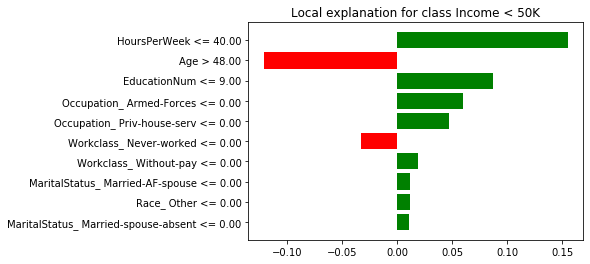

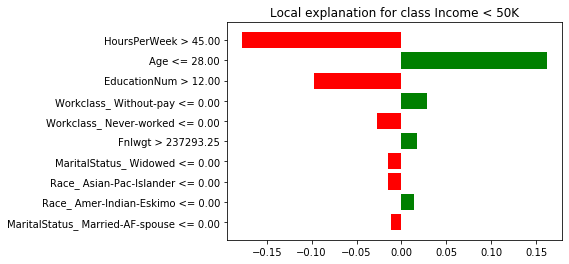

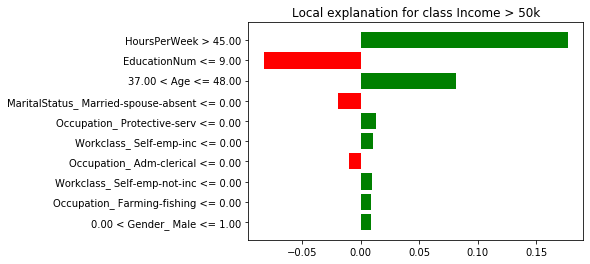

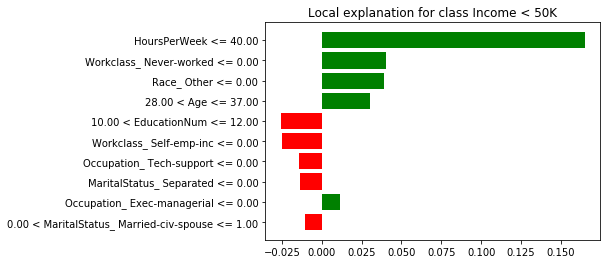

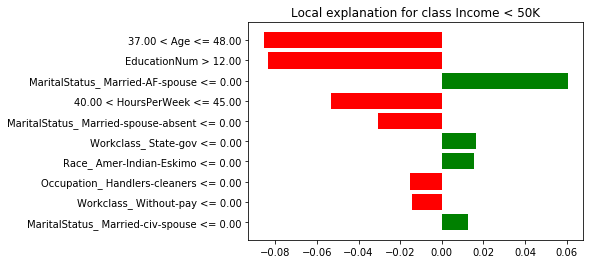

In [12]:
#SP Lime for gnb

sp_obj = submodular_pick.SubmodularPick(explainer, X_train.values, gnb.predict_proba, sample_size=500, num_features=10, num_exps_desired=5)
#Plot the 5 explanations
[exp.as_pyplot_figure(label=exp.available_labels()[0]) for exp in sp_obj.sp_explanations];
# Make it into a dataframe
W_pick=pd.DataFrame([dict(this.as_list(this.available_labels()[0])) for this in sp_obj.sp_explanations]).fillna(0)
 
W_pick['prediction'] = [this.available_labels()[0] for this in sp_obj.sp_explanations]
 
#Making a dataframe of all the explanations of sampled points
W=pd.DataFrame([dict(this.as_list(this.available_labels()[0])) for this in sp_obj.explanations]).fillna(0)
W['prediction'] = [this.available_labels()[0] for this in sp_obj.explanations]
